### Naive Baiyes Implementation
#### Variants : CountVectorization + ngram(1,2 & 3)
#### Variants : TF-IDF + ngram(1,2 & 3)

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

mps:0
mps:0


## PRE-PROCESSING

In [5]:
# Basic utilities
import os
import platform

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation, data splitting, and vectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report, metrics)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.model_selection import GridSearchCV

In [6]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: arm64
Platform: macOS-13.5-arm64-i386-64bit
Mac Version: ('13.5', ('', '', ''), 'arm64')
Processor: i386
Python Version: 3.11.4


In [7]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.0
ipykernel        : 6.19.2
ipywidgets       : 8.0.4
jupyter_client   : 7.4.9
jupyter_core     : 5.3.0
jupyter_server   : 1.23.4
jupyterlab       : 3.6.3
nbclient         : 0.5.13
nbconvert        : 6.5.4
nbformat         : 5.7.0
notebook         : 6.5.4
qtconsole        : 5.4.2
traitlets        : 5.7.1


In [9]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project/Datasets/SEntFiN-v1.1.csv'
df = pd.read_csv(data_pth)
df

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8
...,...,...,...,...
10748,10749,"Negative on Chambal, Advanta: Mitesh Thacker","{""Chambal"": ""negative"", ""Advanta"": ""negative""}",6
10749,10750,"Small, Mid-cap stocks may emerge outperformers","{""Small"": ""positive"", ""Mid-cap stocks"": ""posit...",6
10750,10751,Rupee slips against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5
10751,10752,Rupee weak against US dollar,"{""Rupee"": ""negative"", ""US dollar"": ""neutral""}",5


#### PRE-PROCESSING STEPS IMPLEMENTED BELOW:-

In [10]:
def filter_rows_by_colon_count(data, column):
    """
    Filters out rows where the count of colons in the specified column exceeds one.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name in which colon count needs to be checked.

    Returns:
    - pd.DataFrame: DataFrame after filtering out specific rows.
    """
    condition = data[column].apply(lambda entry: str(entry).count(':') > 1)
    return data[~condition]

In [11]:
df = filter_rows_by_colon_count(df, 'Decisions')
print(f"Post Filtering Stage-1 Step-1: Total Rows - {len(df)}")

Post Filtering Stage-1 Step-1: Total Rows - 7903


In [12]:
def transform_decision_data(data, column):
    """
    Transforms the specified column of the DataFrame by extracting 'Entity' and 'Polarity' 
    from a dictionary representation. Ensures that strings mimicking dictionaries are 
    converted to actual dictionaries.

    Parameters:
    - data (pd.DataFrame): The DataFrame to be processed.
    - column (str): The column name which contains dictionary or its string representation.

    Returns:
    - pd.DataFrame: Transformed DataFrame with 'Headlines', 'Entity', and 'Sentiment' columns.
    """
    data_copy = data.copy()
    
    # Convert string representation of dictionary to actual dictionary
    data_copy[column] = data_copy[column].apply(lambda item: ast.literal_eval(item) if isinstance(item, str) else item)
    
    # Extract key and value from the dictionary
    data_copy['Entity'] = data_copy[column].apply(lambda item: list(item.keys())[0] if isinstance(item, dict) else None)
    data_copy['Sentiment'] = data_copy[column].apply(lambda item: list(item.values())[0] if isinstance(item, dict) else None)
    
    return data_copy[['Title', 'Entity', 'Sentiment']].rename(columns={'Title': 'Headlines'})

processed_df = transform_decision_data(df, 'Decisions')

#Dropping the entity column as the rest have been set aside in the transform_decision_data
processed_df = processed_df.drop(columns=['Entity'])


print(f"Post Filtering Stage-1 Step-2: Total Rows - {len(processed_df)}")

Post Filtering Stage-1 Step-2: Total Rows - 7903


In [13]:
def check_missing_data(dataframe):
    """
    Checks and returns the number of missing values in each column of a DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame to be checked.

    Returns:
    - Series: Number of missing values for each column.
    """
    return dataframe.isnull().sum()

print("Missing Values:\n", check_missing_data(processed_df))
processed_df = processed_df.dropna()
print(f"Post Filtering Stage-2 Step-1: Total Rows - {len(processed_df)}")

Missing Values:
 Headlines    0
Sentiment    0
dtype: int64
Post Filtering Stage-2 Step-1: Total Rows - 7903


In [14]:
def refine_headlines(column):
    """
    Cleans and refines a given text column. The function lowercases the text, removes 
    HTML content, URLs, non-alphanumeric characters, and stopwords. It also lemmatises 
    each word for better text consistency.

    Parameters:
    - column (pd.Series): The column containing text data to be refined.

    Returns:
    - pd.Series: The refined column.
    """
    column = column.str.lower()
    
    # Check if text looks like filename or not
    def extract_text(text):
        if re.match(r'^[A-Za-z0-9_\-\.]+$', text):
            return text
        return BeautifulSoup(text, 'lxml').get_text()
    
    column = column.str.replace('http\S+|www.\S+|[^\w\s]', '', regex=True)
    
  #  lemmatizer = WordNetLemmatizer()
  #   stop_words = set(stopwords.words('english'))
  #  column = column.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    
    return column

processed_df['Headlines'] = refine_headlines(processed_df['Headlines'])
print(f"Post Filtering Stage-2 Step-2: Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-2: Total Rows - 7903


In [15]:
# Detect and remove duplicate rows from the DataFrame
duplicated_rows = processed_df[processed_df.duplicated()]
processed_df.drop_duplicates(inplace=True)
print(f"Post Filtering Stage-2 Step-3 Total Rows - {len(processed_df)}")


Post Filtering Stage-2 Step-3 Total Rows - 7858


In [16]:
def display_sentiment_counts(dataframe, column_name='Sentiment'):
    """
    Displays the frequency and relative percentage of each sentiment value in the given DataFrame.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing sentiment data.
    - column_name (str, optional): The name of the column containing sentiment values. Default is 'Sentiment'.

    Prints:
    - Sentiment counts and their relative percentages.
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(processed_df)



Count of each sentiment:
positive    2830
neutral     2657
negative    2371
Name: Sentiment, dtype: int64
positive    36.014253
neutral     33.812675
negative    30.173072
Name: Sentiment, dtype: float64


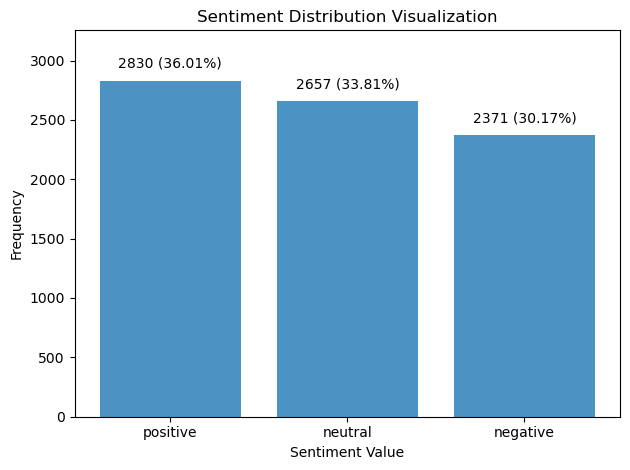

In [17]:
# Calculate and visualize the distribution of sentiment values in the DataFrame using a bar chart.
# Each bar is labelled with the sentiment count and its relative percentage.

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = processed_df['Sentiment'].value_counts()
sentiment_ratio = processed_df['Sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

In [18]:
processed_df

,Headlines,Sentiment
0,spicejet to issue 64 crore warrants to promoters,neutral
1,mmtc q2 net loss at rs 104 crore,neutral
2,midcap funds can deliver more stay put experts,positive
3,mid caps now turn into market darlings,positive
4,market seeing patience if not conviction praka...,neutral
...,...,...
10697,vedantacairn deal may not go through ajay bagga,negative
10700,wall street opens flat sp 500 near record,neutral
10710,heard on the street dutchman mf fiis,neutral
10714,rebound for russia and china lifts stocks,positive


### Common Functions to be used:-

In [19]:
def display_sentences(true_labels, predicted_labels, input_sentences, num_samples=5):
    """
    Prints misclassified sentences given the true labels, predicted labels, and the input sentences.
    
    Parameters:
    - true_labels: Actual labels.
    - predicted_labels: Labels predicted by the classifier.
    - input_sentences: The raw input sentences for displaying misclassified instances.
    - num_samples: Number of misclassified samples to display for each sentiment.
    
    Returns:
    None.
    """
    true_labels_array = np.array(true_labels)
    misclassified_indices = np.where(true_labels_array != predicted_labels)[0]

    sentiment_list = np.unique(true_labels)
    
    for sentiment in sentiment_list:
        count = 0
        print(f"\nMisclassified headlines for {sentiment} sentiment:")
        
        for idx in misclassified_indices:
            if true_labels_array[idx] == sentiment:
                print(f"Actual: {true_labels_array[idx]}, Predicted: {predicted_labels[idx]}, headlines: {input_sentences[idx]}")
                count += 1
            if count == num_samples:
                break
    print("\n")


In [21]:
def display_report(classifier_name, true_labels, predicted_labels, set_name):
    """
    Evaluate the performance of a classifier and display results including confusion matrix.
    
    Parameters:
    - classifier_name: Name of the classifier.
    - true_labels: Actual labels.
    - predicted_labels: Labels predicted by the classifier.
    - set_name: Dataset name (e.g., Validation, Test).
    - input_sentences: The raw input sentences for displaying misclassified instances.
    
    Returns:
    None.
    """
    # Display the name of the classifier and dataset
    print(f"Results for {classifier_name} on {set_name} Set:")
    
    # Display the classification report
    report = metrics.classification_report(true_labels, predicted_labels, target_names=np.unique(true_labels), digits=4)
    print(report)
    
    # Compute and display confusion matrix
    cm = metrics.confusion_matrix(true_labels, predicted_labels)
    
    specificities = []
    fprs = []
    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        
        specificities.append(specificity)
        fprs.append(fpr)

    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)
    weighted_avg_spec = sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values
    weighted_avg_fpr = sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values
    
    macro_avg_spec = sum(specificities) / 3
    macro_avg_fpr = sum(fprs) / 3
    
    labels = np.unique(true_labels)

    print("\nSpecificity per class:")
    for i in range(3):
        print(f"{labels[i]}: {specificities[i]:.4f}")
        
    print("\nFalse Positive Rate (FPR) per class:")
    for i in range(3):
        print(f"{labels[i]}: {fprs[i]:.4f}")
        
    print(f"\nWeighted average specificity: {weighted_avg_spec:.4f}")
    print(f"Weighted average FPR: {weighted_avg_fpr:.4f}")
    print(f"\nMacro average specificity: {macro_avg_spec:.4f}")
    print(f"Macro average FPR: {macro_avg_fpr:.4f}")

    # Display confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{classifier_name} Confusion Matrix ({set_name})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [22]:
# Instantiating the tokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [23]:
param_grid = {
    "Multinomial NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False]
    },
    "Bernoulli NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False],
        'binarize': [0.0, 0.5, 1.0]
    },
    "Complement NB": {
        'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        'fit_prior': [True, False],
        'norm': [True, False]
    }
}

In [24]:
# Extracting the raw sentences using indices from previous splits
sentences = processed_df['Headlines'].tolist()
train_indices, temp_indices = train_test_split(np.arange(len(sentences)), test_size=0.3, random_state=5)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=5)

sentences_train = [sentences[i] for i in train_indices]
sentences_val = [sentences[i] for i in val_indices]
sentences_test = [sentences[i] for i in test_indices]

### CV = 1ngram + Naive Baiyes Implementation

In [25]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize, token_pattern=None)
# Transforming the data
text_counts = cv.fit_transform(processed_df['Headlines'])

In [26]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [27]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [28]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 1.0
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7500    0.6954    0.7217       371
     neutral     0.7297    0.7020    0.7156       396
    positive     0.7026    0.7743    0.7367       412

    accuracy                         0.7252      1179
   macro avg     0.7274    0.7239    0.7247      1179
weighted avg     0.7266    0.7252    0.7249      1179


Specificity per class:
negative: 0.8741
neutral: 0.8485
positive: 0.7988

False Positive Rate (FPR) per class:
negative: 0.1259
neutral: 0.1515
positive: 0.2012

Weighted average specificity: 0.8392
Weighted average FPR: 0.1608

Macro average specificity: 0.8405
Macro average FPR: 0.1595


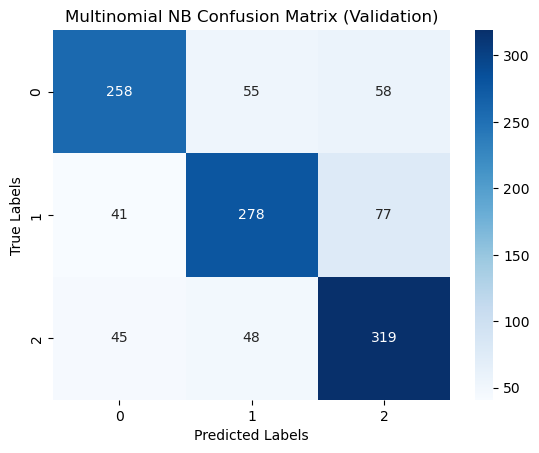

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7262    0.7139    0.7200       353
     neutral     0.7672    0.7455    0.7562       389
    positive     0.7335    0.7620    0.7475       437

    accuracy                         0.7422      1179
   macro avg     0.7423    0.7405    0.7412      1179
weighted avg     0.7424    0.7422    0.7421      1179


Specificity per class:
negative: 0.8677
neutral: 0.8692
positive: 0.8175

False Positive Rate (FPR) per class:
negative: 0.1323
neutral: 0.1308
positive: 0.1825

Weighted average specificity: 0.8496
Weighted average FPR: 0.1504

Macro average specificity: 0.8515
Macro average FPR: 0.1485


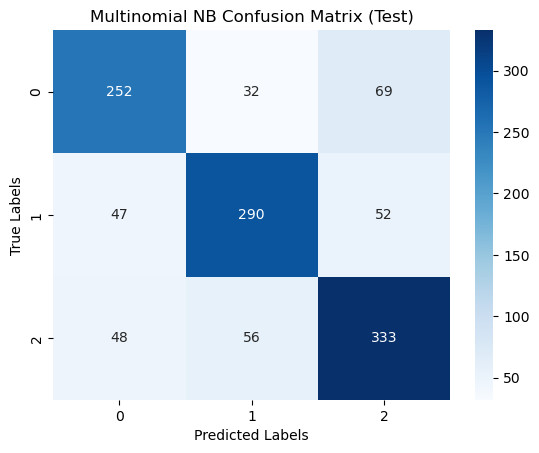

In [29]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [30]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 n

In [31]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [32]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 1.0
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7704    0.6604    0.7112       371
     neutral     0.7196    0.7323    0.7259       396
    positive     0.6965    0.7743    0.7333       412

    accuracy                         0.7243      1179
   macro avg     0.7288    0.7223    0.7235      1179
weighted avg     0.7275    0.7243    0.7239      1179


Specificity per class:
negative: 0.8930
neutral: 0.8331
positive: 0.7938

False Positive Rate (FPR) per class:
negative: 0.1070
neutral: 0.1669
positive: 0.2062

Weighted average specificity: 0.8382
Weighted average FPR: 0.1618

Macro average specificity: 0.8399
Macro average FPR: 0.1601


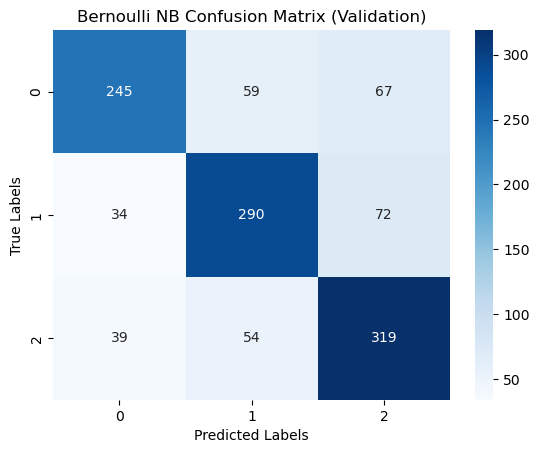

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7594    0.6884    0.7221       353
     neutral     0.7433    0.7892    0.7656       389
    positive     0.7377    0.7529    0.7452       437

    accuracy                         0.7455      1179
   macro avg     0.7468    0.7435    0.7443      1179
weighted avg     0.7460    0.7455    0.7450      1179


Specificity per class:
negative: 0.8920
neutral: 0.8437
positive: 0.8246

False Positive Rate (FPR) per class:
negative: 0.1080
neutral: 0.1563
positive: 0.1754

Weighted average specificity: 0.8511
Weighted average FPR: 0.1489

Macro average specificity: 0.8534
Macro average FPR: 0.1466


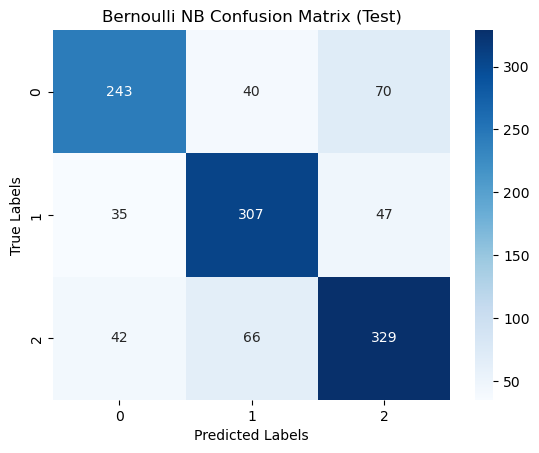

In [33]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [34]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 n

In [35]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [36]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: False


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7706    0.7062    0.7370       371
     neutral     0.7273    0.7273    0.7273       396
    positive     0.7223    0.7767    0.7485       412

    accuracy                         0.7379      1179
   macro avg     0.7401    0.7367    0.7376      1179
weighted avg     0.7392    0.7379    0.7378      1179


Specificity per class:
negative: 0.8863
neutral: 0.8435
positive: 0.8172

False Positive Rate (FPR) per class:
negative: 0.1137
neutral: 0.1565
positive: 0.1828

Weighted average specificity: 0.8478
Weighted average FPR: 0.1522

Macro average specificity: 0.8490
Macro average FPR: 0.1510


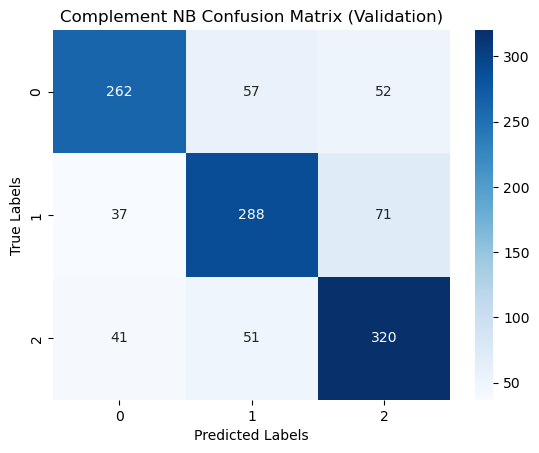

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7515    0.7280    0.7396       353
     neutral     0.7656    0.7892    0.7772       389
    positive     0.7454    0.7437    0.7446       437

    accuracy                         0.7540      1179
   macro avg     0.7542    0.7537    0.7538      1179
weighted avg     0.7539    0.7540    0.7538      1179


Specificity per class:
negative: 0.8815
neutral: 0.8609
positive: 0.8356

False Positive Rate (FPR) per class:
negative: 0.1185
neutral: 0.1391
positive: 0.1644

Weighted average specificity: 0.8577
Weighted average FPR: 0.1423

Macro average specificity: 0.8593
Macro average FPR: 0.1407


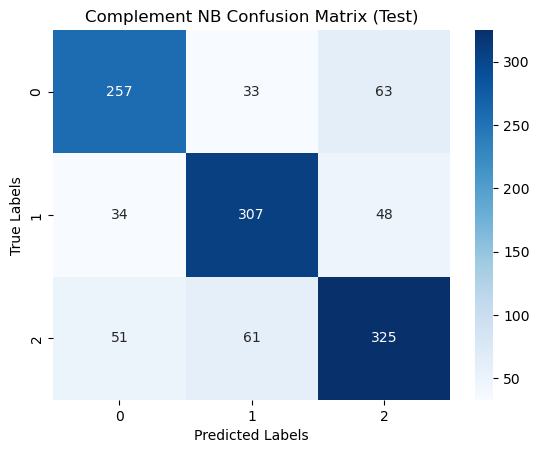

In [37]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [38]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 329

### CV = 2ngram + Naive Baiyes Implementation

In [39]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data
text_counts = cv.fit_transform(processed_df['Headlines'])

In [40]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [41]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [42]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 1.5
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6452    0.5930    0.6180       371
     neutral     0.6138    0.6742    0.6426       396
    positive     0.6452    0.6311    0.6380       412

    accuracy                         0.6336      1179
   macro avg     0.6347    0.6328    0.6329      1179
weighted avg     0.6346    0.6336    0.6333      1179


Specificity per class:
negative: 0.8133
neutral: 0.7407
positive: 0.7730

False Positive Rate (FPR) per class:
negative: 0.1867
neutral: 0.2593
positive: 0.2270

Weighted average specificity: 0.7748
Weighted average FPR: 0.2252

Macro average specificity: 0.7757
Macro average FPR: 0.2243


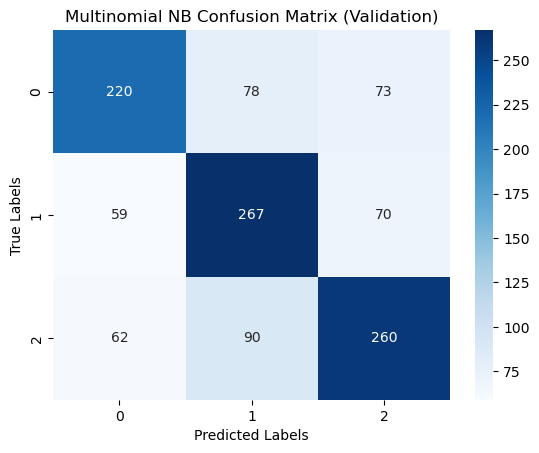

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6415    0.5779    0.6080       353
     neutral     0.6058    0.7506    0.6705       389
    positive     0.6649    0.5767    0.6176       437

    accuracy                         0.6344      1179
   macro avg     0.6374    0.6351    0.6321      1179
weighted avg     0.6384    0.6344    0.6322      1179


Specificity per class:
negative: 0.8267
neutral: 0.7059
positive: 0.7961

False Positive Rate (FPR) per class:
negative: 0.1733
neutral: 0.2941
positive: 0.2039

Weighted average specificity: 0.7755
Weighted average FPR: 0.2245

Macro average specificity: 0.7763
Macro average FPR: 0.2237


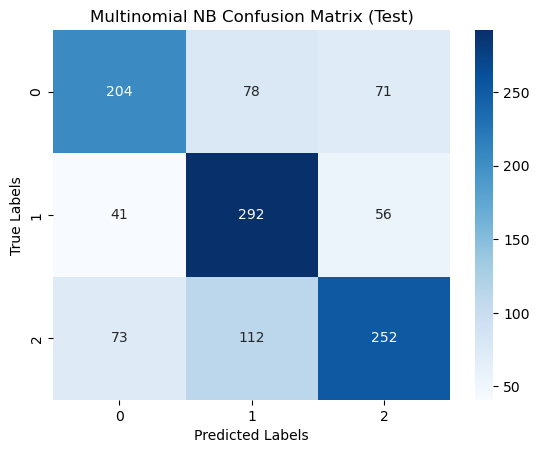

In [43]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [44]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 ne

In [45]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [46]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7569    0.5202    0.6166       371
     neutral     0.6112    0.7424    0.6705       396
    positive     0.6298    0.6772    0.6526       412

    accuracy                         0.6497      1179
   macro avg     0.6660    0.6466    0.6466      1179
weighted avg     0.6635    0.6497    0.6473      1179


Specificity per class:
negative: 0.9024
neutral: 0.7162
positive: 0.7481

False Positive Rate (FPR) per class:
negative: 0.0976
neutral: 0.2838
positive: 0.2519

Weighted average specificity: 0.7859
Weighted average FPR: 0.2141

Macro average specificity: 0.7889
Macro average FPR: 0.2111


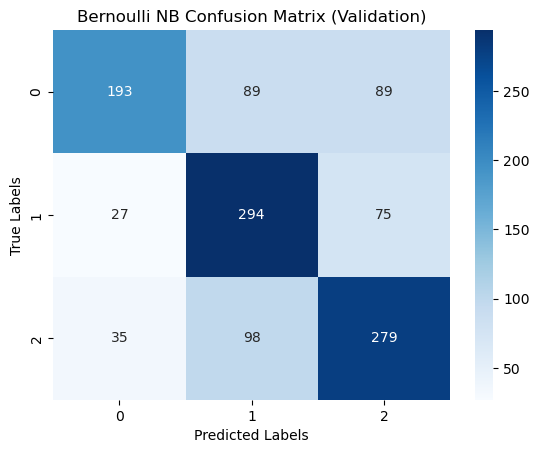

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7500    0.5184    0.6131       353
     neutral     0.5867    0.7918    0.6740       389
    positive     0.6610    0.6201    0.6399       437

    accuracy                         0.6463      1179
   macro avg     0.6659    0.6434    0.6423      1179
weighted avg     0.6631    0.6463    0.6431      1179


Specificity per class:
negative: 0.9047
neutral: 0.6766
positive: 0.7794

False Positive Rate (FPR) per class:
negative: 0.0953
neutral: 0.3234
positive: 0.2206

Weighted average specificity: 0.7830
Weighted average FPR: 0.2170

Macro average specificity: 0.7869
Macro average FPR: 0.2131


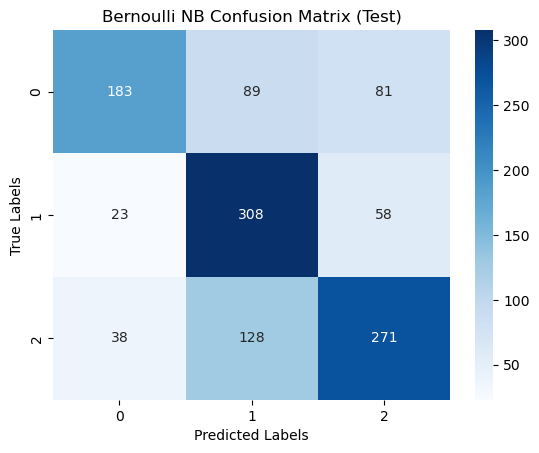

In [47]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [48]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: rbi to conduct 14d

In [49]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [50]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 1.0
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.5170    0.7385    0.6082       371
     neutral     0.6912    0.4747    0.5629       396
    positive     0.6737    0.6165    0.6439       412

    accuracy                         0.6073      1179
   macro avg     0.6273    0.6099    0.6050      1179
weighted avg     0.6303    0.6073    0.6054      1179


Specificity per class:
negative: 0.6332
neutral: 0.8627
positive: 0.7897

False Positive Rate (FPR) per class:
negative: 0.3668
neutral: 0.1373
positive: 0.2103

Weighted average specificity: 0.7650
Weighted average FPR: 0.2350

Macro average specificity: 0.7619
Macro average FPR: 0.2381


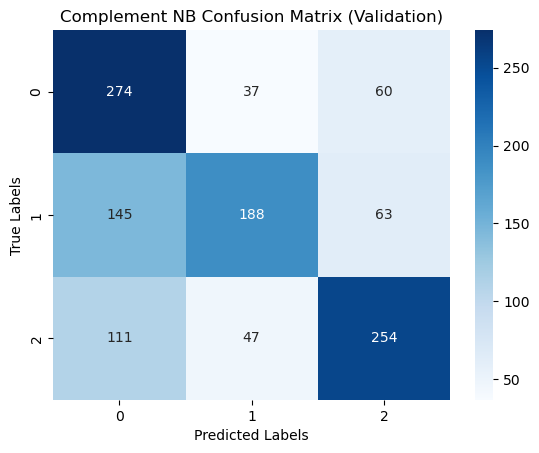

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.5019    0.7394    0.5979       353
     neutral     0.7331    0.5296    0.6149       389
    positive     0.6852    0.5927    0.6356       437

    accuracy                         0.6158      1179
   macro avg     0.6401    0.6205    0.6161      1179
weighted avg     0.6461    0.6158    0.6175      1179


Specificity per class:
negative: 0.6423
neutral: 0.8739
positive: 0.7969

False Positive Rate (FPR) per class:
negative: 0.3577
neutral: 0.1261
positive: 0.2031

Weighted average specificity: 0.7760
Weighted average FPR: 0.2240

Macro average specificity: 0.7710
Macro average FPR: 0.2290


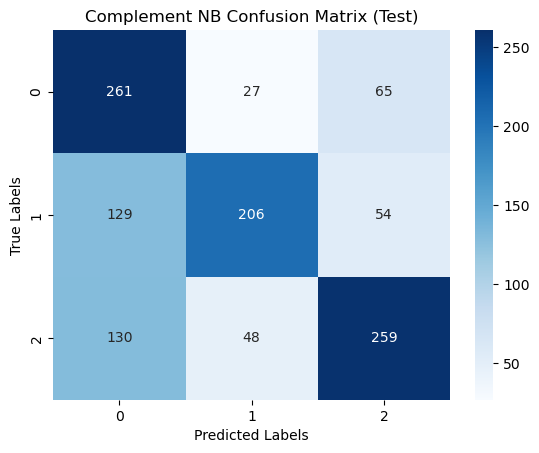

In [51]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [52]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: negative, headlines: nifty to consolidate at current levels 9

### CV = 3ngram + Naive Baiyes Implementation

In [53]:
# Initializing the CountVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(3,3), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data
text_counts = cv.fit_transform(processed_df['Headlines'])

In [54]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_counts, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [55]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [56]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 1.0
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.6564    0.2884    0.4007       371
     neutral     0.4021    0.8611    0.5482       396
    positive     0.6548    0.2670    0.3793       412

    accuracy                         0.4733      1179
   macro avg     0.5711    0.4722    0.4428      1179
weighted avg     0.5704    0.4733    0.4428      1179


Specificity per class:
negative: 0.8895
neutral: 0.2997
positive: 0.8854

False Positive Rate (FPR) per class:
negative: 0.1105
neutral: 0.7003
positive: 0.1146

Weighted average specificity: 0.6900
Weighted average FPR: 0.3100

Macro average specificity: 0.6915
Macro average FPR: 0.3085


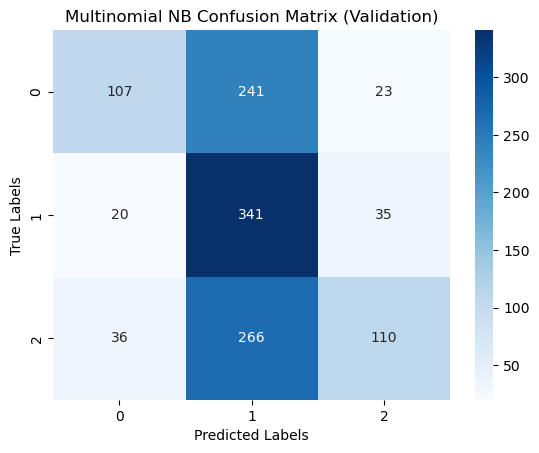

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.6761    0.2720    0.3879       353
     neutral     0.4012    0.8715    0.5494       389
    positive     0.6354    0.2792    0.3879       437

    accuracy                         0.4724      1179
   macro avg     0.5709    0.4742    0.4417      1179
weighted avg     0.5703    0.4724    0.4412      1179


Specificity per class:
negative: 0.9093
neutral: 0.3011
positive: 0.8614

False Positive Rate (FPR) per class:
negative: 0.0907
neutral: 0.6989
positive: 0.1386

Weighted average specificity: 0.6909
Weighted average FPR: 0.3091

Macro average specificity: 0.6906
Macro average FPR: 0.3094


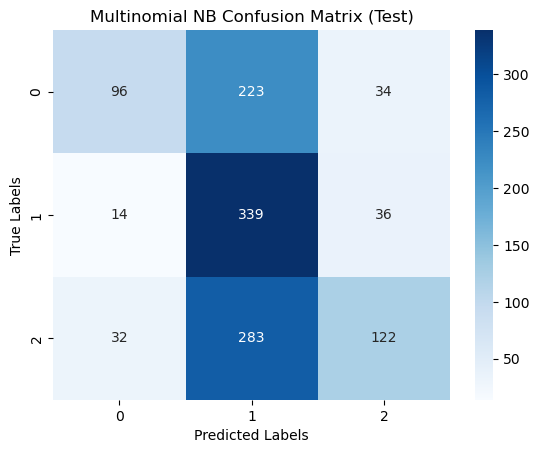

In [57]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [58]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: neutral, headlines: metal stocks sink as china pmi data raises demand concerns
Actual: negative, Predicted: neutral, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: amtek auto tumbles on default fears
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 32935 cr
Actual: neutral, Predi

In [59]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [60]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.1
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4405    0.5687    0.4965       371
     neutral     0.4542    0.6641    0.5395       396
    positive     0.7934    0.2330    0.3602       412

    accuracy                         0.4835      1179
   macro avg     0.5627    0.4886    0.4654      1179
weighted avg     0.5684    0.4835    0.4633      1179


Specificity per class:
negative: 0.5726
neutral: 0.4928
positive: 0.9499

False Positive Rate (FPR) per class:
negative: 0.4274
neutral: 0.5072
positive: 0.0501

Weighted average specificity: 0.6776
Weighted average FPR: 0.3224

Macro average specificity: 0.6717
Macro average FPR: 0.3283


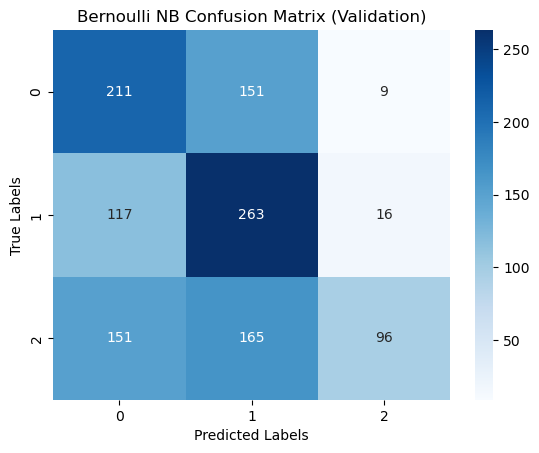

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4258    0.5524    0.4809       353
     neutral     0.4400    0.6504    0.5249       389
    positive     0.7466    0.2494    0.3739       437

    accuracy                         0.4724      1179
   macro avg     0.5374    0.4841    0.4599      1179
weighted avg     0.5494    0.4724    0.4558      1179


Specificity per class:
negative: 0.5792
neutral: 0.4856
positive: 0.9237

False Positive Rate (FPR) per class:
negative: 0.4208
neutral: 0.5144
positive: 0.0763

Weighted average specificity: 0.6760
Weighted average FPR: 0.3240

Macro average specificity: 0.6628
Macro average FPR: 0.3372


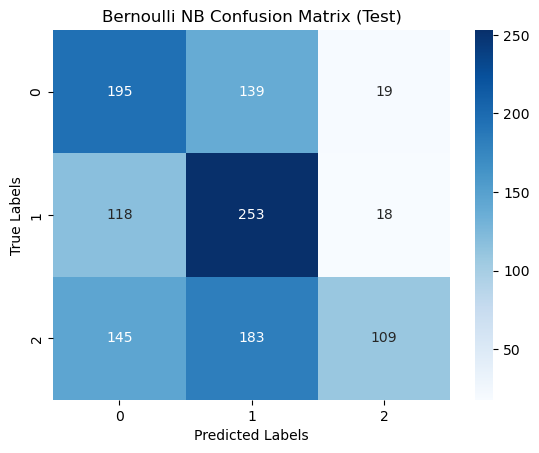

In [61]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [62]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: neutral, headlines: amtek auto tumbles on default fears
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure
Actual: negative, Predicted: neutral, headlines: bonds retreats on fresh selling call rates recover
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: negative, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 32935 cr
Actual: neutral, Predicted: negative, headline

In [63]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [64]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 0.5
fit_prior: True
norm: False


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3710    0.9380    0.5317       371
     neutral     0.6930    0.1995    0.3098       396
    positive     0.7795    0.2403    0.3673       412

    accuracy                         0.4461      1179
   macro avg     0.6145    0.4593    0.4030      1179
weighted avg     0.6219    0.4461    0.3997      1179


Specificity per class:
negative: 0.2318
neutral: 0.9274
positive: 0.9385

False Positive Rate (FPR) per class:
negative: 0.7682
neutral: 0.0726
positive: 0.0615

Weighted average specificity: 0.7124
Weighted average FPR: 0.2876

Macro average specificity: 0.6992
Macro average FPR: 0.3008


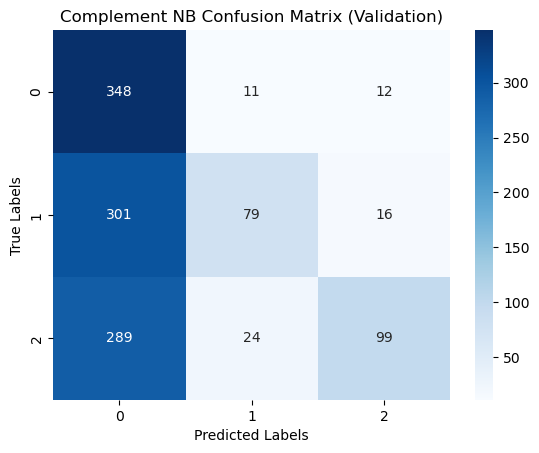

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3577    0.9008    0.5121       353
     neutral     0.6741    0.2339    0.3473       389
    positive     0.7419    0.2632    0.3885       437

    accuracy                         0.4444      1179
   macro avg     0.5912    0.4660    0.4160      1179
weighted avg     0.6045    0.4444    0.4119      1179


Specificity per class:
negative: 0.2651
neutral: 0.9078
positive: 0.9109

False Positive Rate (FPR) per class:
negative: 0.7349
neutral: 0.0922
positive: 0.0891

Weighted average specificity: 0.7165
Weighted average FPR: 0.2835

Macro average specificity: 0.6946
Macro average FPR: 0.3054


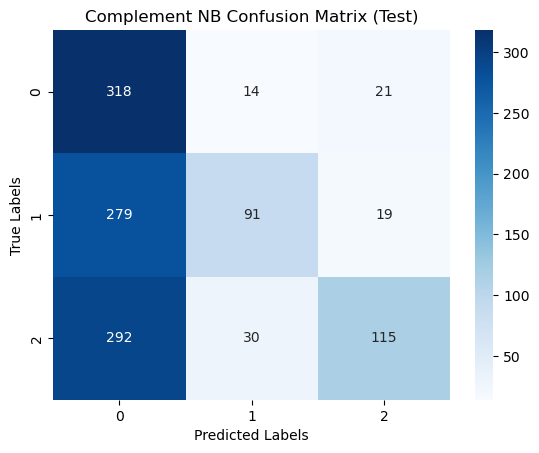

In [65]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [66]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: jaypee infratech q1 net profit down 1171 to rs 20994 cr
Actual: negative, Predicted: positive, headlines: ashiana housing q1 net falls 17 pc to rs 797 crore
Actual: negative, Predicted: neutral, headlines: idbi bank to sell 5 per cent stake in national stock exchange

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: negative, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 6150 on the nifty looks a matter of time ashwani gujral
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekha

### TF-IDF ngram=1 + Naive Bayes Implementation

In [67]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(processed_df['Headlines'])

In [68]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [69]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [70]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 1.5
fit_prior: False


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7559    0.6927    0.7229       371
     neutral     0.7555    0.6944    0.7237       396
    positive     0.6926    0.7985    0.7418       412

    accuracy                         0.7303      1179
   macro avg     0.7347    0.7286    0.7295      1179
weighted avg     0.7336    0.7303    0.7298      1179


Specificity per class:
negative: 0.8792
neutral: 0.8681
positive: 0.7847

False Positive Rate (FPR) per class:
negative: 0.1208
neutral: 0.1319
positive: 0.2153

Weighted average specificity: 0.8424
Weighted average FPR: 0.1576

Macro average specificity: 0.8440
Macro average FPR: 0.1560


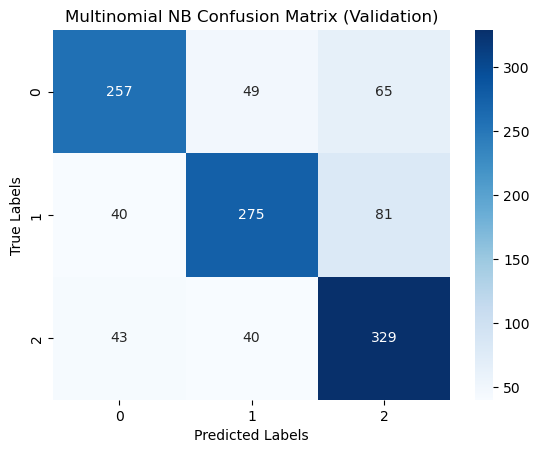

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7412    0.7139    0.7273       353
     neutral     0.7737    0.7558    0.7646       389
    positive     0.7342    0.7712    0.7522       437

    accuracy                         0.7489      1179
   macro avg     0.7497    0.7469    0.7480      1179
weighted avg     0.7493    0.7489    0.7488      1179


Specificity per class:
negative: 0.8776
neutral: 0.8726
positive: 0.8174

False Positive Rate (FPR) per class:
negative: 0.1224
neutral: 0.1274
positive: 0.1826

Weighted average specificity: 0.8536
Weighted average FPR: 0.1464

Macro average specificity: 0.8559
Macro average FPR: 0.1441


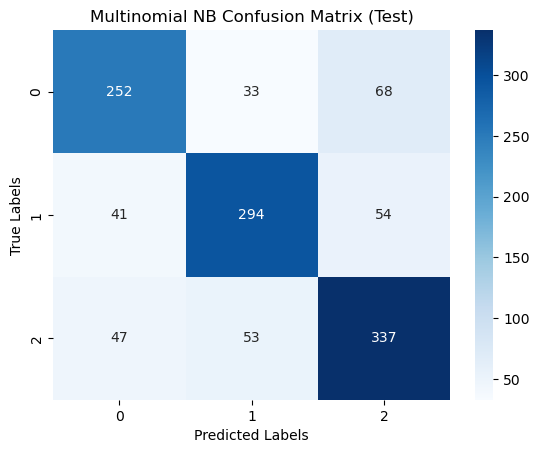

In [71]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [72]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 3293

In [73]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [74]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 1.0
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7704    0.6604    0.7112       371
     neutral     0.7196    0.7323    0.7259       396
    positive     0.6965    0.7743    0.7333       412

    accuracy                         0.7243      1179
   macro avg     0.7288    0.7223    0.7235      1179
weighted avg     0.7275    0.7243    0.7239      1179


Specificity per class:
negative: 0.8930
neutral: 0.8331
positive: 0.7938

False Positive Rate (FPR) per class:
negative: 0.1070
neutral: 0.1669
positive: 0.2062

Weighted average specificity: 0.8382
Weighted average FPR: 0.1618

Macro average specificity: 0.8399
Macro average FPR: 0.1601


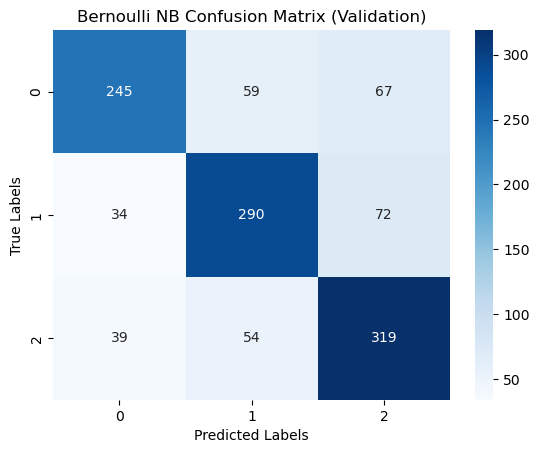

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7594    0.6884    0.7221       353
     neutral     0.7433    0.7892    0.7656       389
    positive     0.7377    0.7529    0.7452       437

    accuracy                         0.7455      1179
   macro avg     0.7468    0.7435    0.7443      1179
weighted avg     0.7460    0.7455    0.7450      1179


Specificity per class:
negative: 0.8920
neutral: 0.8437
positive: 0.8246

False Positive Rate (FPR) per class:
negative: 0.1080
neutral: 0.1563
positive: 0.1754

Weighted average specificity: 0.8511
Weighted average FPR: 0.1489

Macro average specificity: 0.8534
Macro average FPR: 0.1466


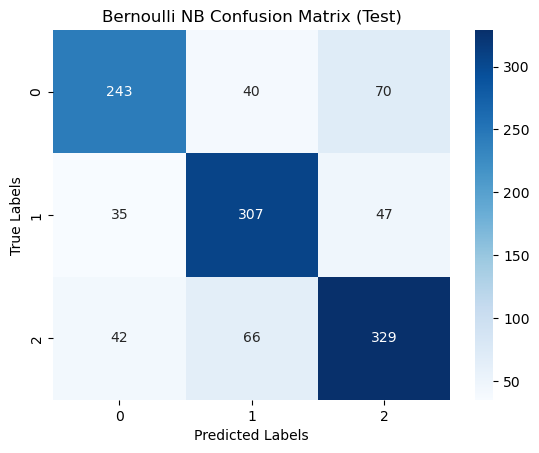

In [75]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [76]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 n

In [77]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [78]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 2.0
fit_prior: True
norm: False


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7715    0.7008    0.7345       371
     neutral     0.7361    0.7045    0.7200       396
    positive     0.7063    0.7937    0.7474       412

    accuracy                         0.7345      1179
   macro avg     0.7380    0.7330    0.7340      1179
weighted avg     0.7368    0.7345    0.7341      1179


Specificity per class:
negative: 0.8873
neutral: 0.8544
positive: 0.7985

False Positive Rate (FPR) per class:
negative: 0.1127
neutral: 0.1456
positive: 0.2015

Weighted average specificity: 0.8452
Weighted average FPR: 0.1548

Macro average specificity: 0.8467
Macro average FPR: 0.1533


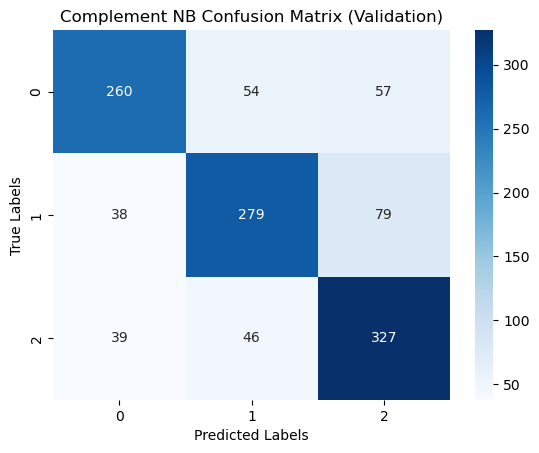

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7660    0.7139    0.7390       353
     neutral     0.7719    0.7918    0.7817       389
    positive     0.7406    0.7643    0.7523       437

    accuracy                         0.7583      1179
   macro avg     0.7595    0.7567    0.7577      1179
weighted avg     0.7585    0.7583    0.7580      1179


Specificity per class:
negative: 0.8929
neutral: 0.8656
positive: 0.8272

False Positive Rate (FPR) per class:
negative: 0.1071
neutral: 0.1344
positive: 0.1728

Weighted average specificity: 0.8595
Weighted average FPR: 0.1405

Macro average specificity: 0.8619
Macro average FPR: 0.1381


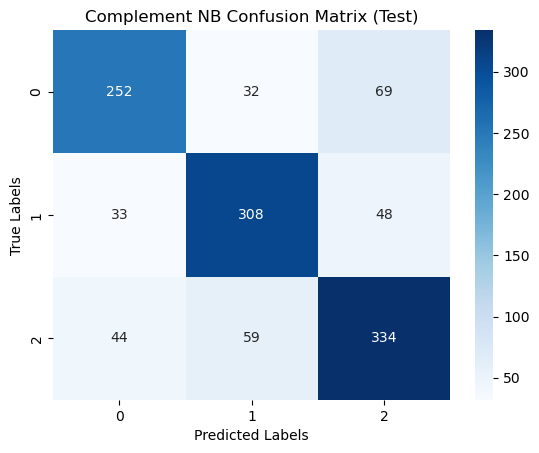

In [79]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [80]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 3293

### TF-IDF ngram=2 + Naive Bayes Implementation

In [81]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), tokenizer=token.tokenize, token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(processed_df['Headlines'])

In [82]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [83]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [84]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 0.1
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.5474    0.7008    0.6147       371
     neutral     0.6636    0.5480    0.6003       396
    positive     0.6605    0.6044    0.6312       412

    accuracy                         0.6158      1179
   macro avg     0.6238    0.6177    0.6154      1179
weighted avg     0.6259    0.6158    0.6156      1179


Specificity per class:
negative: 0.6843
neutral: 0.8223
positive: 0.7884

False Positive Rate (FPR) per class:
negative: 0.3157
neutral: 0.1777
positive: 0.2116

Weighted average specificity: 0.7670
Weighted average FPR: 0.2330

Macro average specificity: 0.7650
Macro average FPR: 0.2350


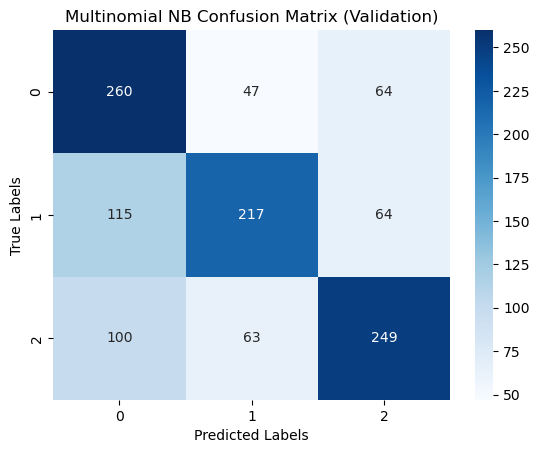

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.5333    0.7025    0.6064       353
     neutral     0.6886    0.5913    0.6362       389
    positive     0.6789    0.5904    0.6316       437

    accuracy                         0.6243      1179
   macro avg     0.6336    0.6281    0.6247      1179
weighted avg     0.6385    0.6243    0.6256      1179


Specificity per class:
negative: 0.6922
neutral: 0.8295
positive: 0.7967

False Positive Rate (FPR) per class:
negative: 0.3078
neutral: 0.1705
positive: 0.2033

Weighted average specificity: 0.7762
Weighted average FPR: 0.2238

Macro average specificity: 0.7728
Macro average FPR: 0.2272


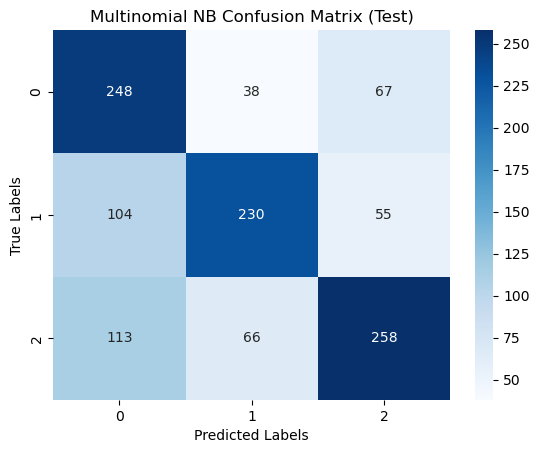

In [85]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [86]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: rbi to conduct 14day term repo auction f

In [87]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [88]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.5
binarize: 0.0
fit_prior: False


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.7569    0.5202    0.6166       371
     neutral     0.6112    0.7424    0.6705       396
    positive     0.6298    0.6772    0.6526       412

    accuracy                         0.6497      1179
   macro avg     0.6660    0.6466    0.6466      1179
weighted avg     0.6635    0.6497    0.6473      1179


Specificity per class:
negative: 0.9024
neutral: 0.7162
positive: 0.7481

False Positive Rate (FPR) per class:
negative: 0.0976
neutral: 0.2838
positive: 0.2519

Weighted average specificity: 0.7859
Weighted average FPR: 0.2141

Macro average specificity: 0.7889
Macro average FPR: 0.2111


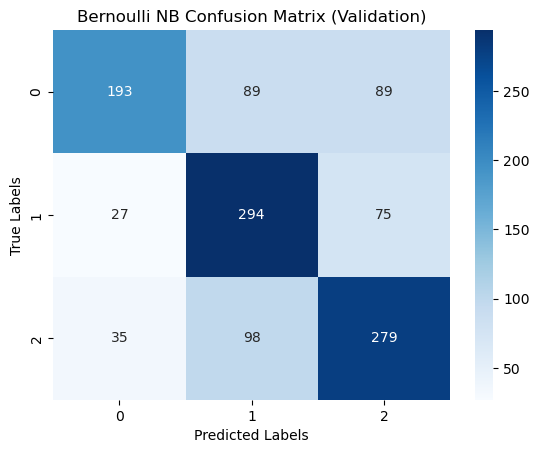

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.7500    0.5184    0.6131       353
     neutral     0.5867    0.7918    0.6740       389
    positive     0.6610    0.6201    0.6399       437

    accuracy                         0.6463      1179
   macro avg     0.6659    0.6434    0.6423      1179
weighted avg     0.6631    0.6463    0.6431      1179


Specificity per class:
negative: 0.9047
neutral: 0.6766
positive: 0.7794

False Positive Rate (FPR) per class:
negative: 0.0953
neutral: 0.3234
positive: 0.2206

Weighted average specificity: 0.7830
Weighted average FPR: 0.2170

Macro average specificity: 0.7869
Macro average FPR: 0.2131


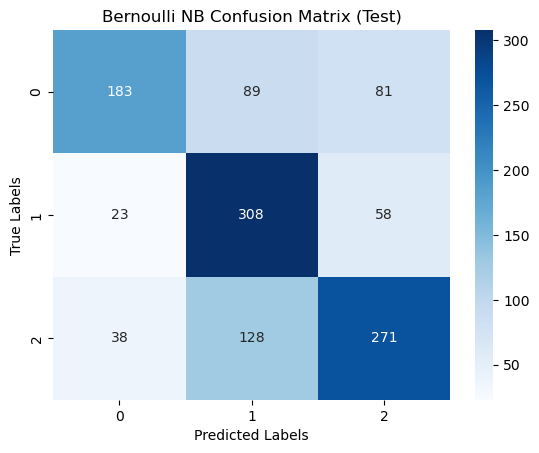

In [89]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [90]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: saintgobain sees big selloff post plans to merge grindwell norton
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: rbi to conduct 14d

In [91]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [92]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 0.5
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.5139    0.7466    0.6088       371
     neutral     0.7019    0.4697    0.5628       396
    positive     0.6667    0.6068    0.6353       412

    accuracy                         0.6047      1179
   macro avg     0.6275    0.6077    0.6023      1179
weighted avg     0.6304    0.6047    0.6026      1179


Specificity per class:
negative: 0.6246
neutral: 0.8696
positive: 0.7874

False Positive Rate (FPR) per class:
negative: 0.3754
neutral: 0.1304
positive: 0.2126

Weighted average specificity: 0.7638
Weighted average FPR: 0.2362

Macro average specificity: 0.7606
Macro average FPR: 0.2394


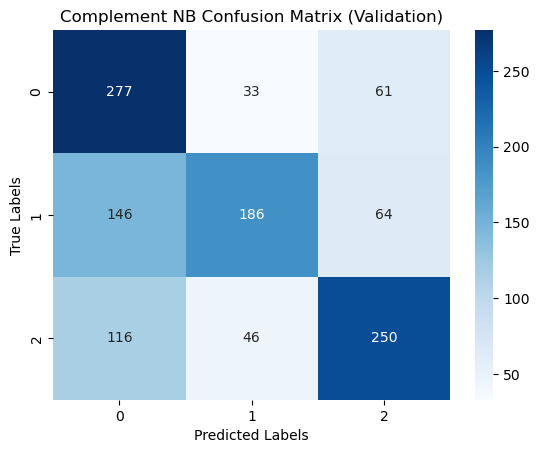

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4990    0.7422    0.5968       353
     neutral     0.7384    0.5296    0.6168       389
    positive     0.6827    0.5858    0.6305       437

    accuracy                         0.6141      1179
   macro avg     0.6400    0.6192    0.6147      1179
weighted avg     0.6461    0.6141    0.6159      1179


Specificity per class:
negative: 0.6372
neutral: 0.8765
positive: 0.7973

False Positive Rate (FPR) per class:
negative: 0.3628
neutral: 0.1235
positive: 0.2027

Weighted average specificity: 0.7755
Weighted average FPR: 0.2245

Macro average specificity: 0.7703
Macro average FPR: 0.2297


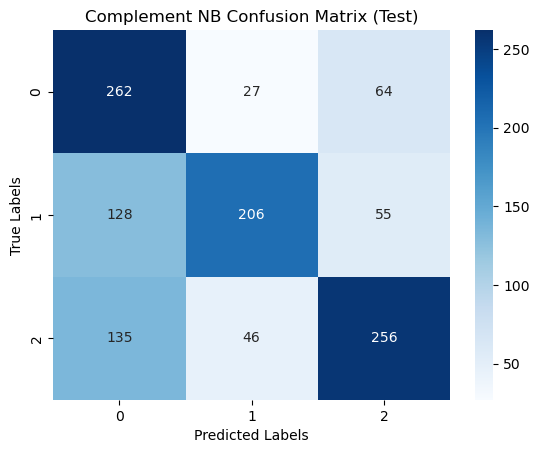

In [93]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [94]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: positive, headlines: anant raj industries will face resistance around 110120 levels rohit shinde
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: sail to speed up coal acquisition plan abroad stock down
Actual: negative, Predicted: positive, headlines: slowing us truck sales to hit bharat forge

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: rbi to conduct 14day term repo auction f

### TF-IDF ngram=3 + Naive Bayes Implementation

In [95]:
# Initialize the TfidfVectorizer with the same settings as CountVectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(3, 3), tokenizer=token.tokenize , token_pattern=None)

# Transforming the data using the TfidfVectorizer
text_tfidf = tfidf.fit_transform(processed_df['Headlines'])

In [96]:
# Spliting the data into a training set, a validation set, and a test set using a 70-15-15 split
X_train, X_temp, Y_train, Y_temp = train_test_split(text_tfidf, processed_df['Sentiment'], test_size=0.3, random_state=5)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=5)

In [97]:
# Multinomial Naive Bayes
classifier_name = "Multinomial NB"
classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [98]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")


Multinomial NB best parameters are:
alpha: 0.1
fit_prior: True


Results for Multinomial NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4954    0.4313    0.4611       371
     neutral     0.4310    0.7803    0.5553       396
    positive     0.7338    0.2476    0.3702       412

    accuracy                         0.4843      1179
   macro avg     0.5534    0.4864    0.4622      1179
weighted avg     0.5571    0.4843    0.4610      1179


Specificity per class:
negative: 0.7160
neutral: 0.3910
positive: 0.9269

False Positive Rate (FPR) per class:
negative: 0.2840
neutral: 0.6090
positive: 0.0731

Weighted average specificity: 0.6806
Weighted average FPR: 0.3194

Macro average specificity: 0.6780
Macro average FPR: 0.3220


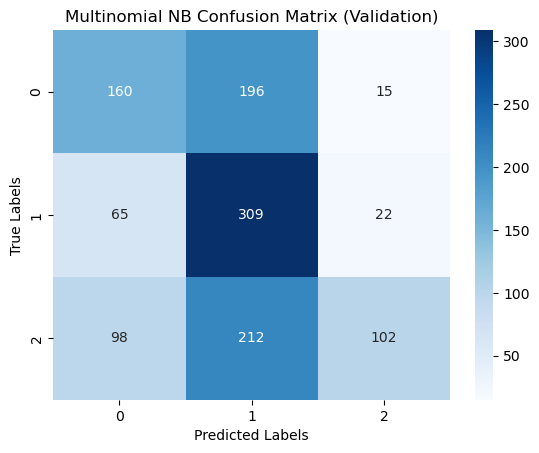

Results for Multinomial NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4895    0.3966    0.4382       353
     neutral     0.4227    0.7866    0.5499       389
    positive     0.6746    0.2609    0.3762       437

    accuracy                         0.4750      1179
   macro avg     0.5289    0.4814    0.4548      1179
weighted avg     0.5360    0.4750    0.4521      1179


Specificity per class:
negative: 0.7420
neutral: 0.3780
positive: 0.8902

False Positive Rate (FPR) per class:
negative: 0.2580
neutral: 0.6220
positive: 0.1098

Weighted average specificity: 0.6768
Weighted average FPR: 0.3232

Macro average specificity: 0.6701
Macro average FPR: 0.3299


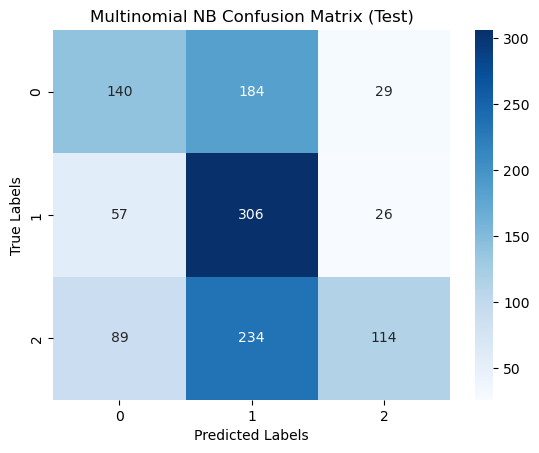

In [99]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [100]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: neutral, headlines: den networks q2 down 2824 per cent at rs 1118 crore
Actual: negative, Predicted: neutral, headlines: amtek auto tumbles on default fears
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure
Actual: negative, Predicted: neutral, headlines: bonds retreats on fresh selling call rates recover
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: positive, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: positive, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 32935 cr
Actual: neutral, Predicted: negative, headlines: 

In [101]:
# Bernoulli Naive Bayes
classifier_name = "Bernoulli NB"
classifier = BernoulliNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [102]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Bernoulli NB best parameters are:
alpha: 0.1
binarize: 0.0
fit_prior: True


Results for Bernoulli NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.4405    0.5687    0.4965       371
     neutral     0.4542    0.6641    0.5395       396
    positive     0.7934    0.2330    0.3602       412

    accuracy                         0.4835      1179
   macro avg     0.5627    0.4886    0.4654      1179
weighted avg     0.5684    0.4835    0.4633      1179


Specificity per class:
negative: 0.5726
neutral: 0.4928
positive: 0.9499

False Positive Rate (FPR) per class:
negative: 0.4274
neutral: 0.5072
positive: 0.0501

Weighted average specificity: 0.6776
Weighted average FPR: 0.3224

Macro average specificity: 0.6717
Macro average FPR: 0.3283


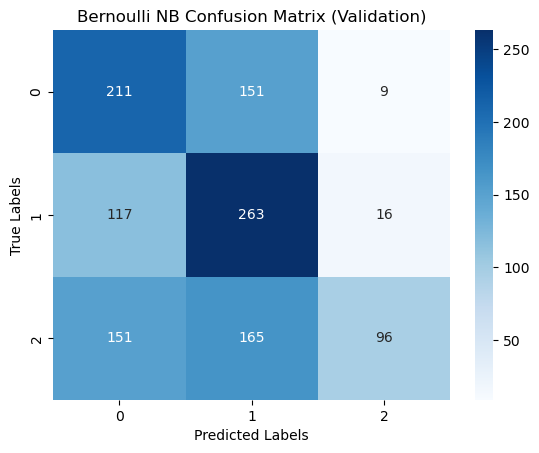

Results for Bernoulli NB on Test Set:
              precision    recall  f1-score   support

    negative     0.4258    0.5524    0.4809       353
     neutral     0.4400    0.6504    0.5249       389
    positive     0.7466    0.2494    0.3739       437

    accuracy                         0.4724      1179
   macro avg     0.5374    0.4841    0.4599      1179
weighted avg     0.5494    0.4724    0.4558      1179


Specificity per class:
negative: 0.5792
neutral: 0.4856
positive: 0.9237

False Positive Rate (FPR) per class:
negative: 0.4208
neutral: 0.5144
positive: 0.0763

Weighted average specificity: 0.6760
Weighted average FPR: 0.3240

Macro average specificity: 0.6628
Macro average FPR: 0.3372


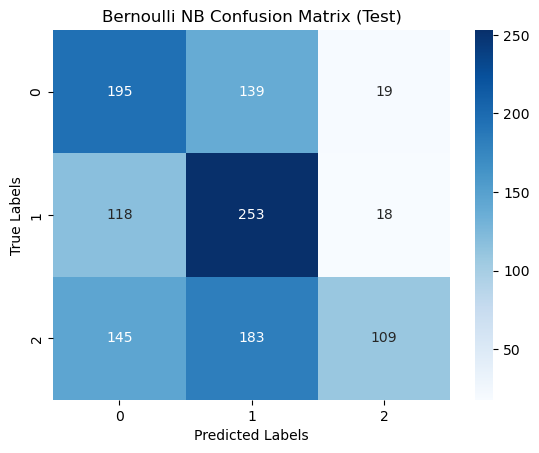

In [103]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [104]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: neutral, headlines: amtek auto tumbles on default fears
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure
Actual: negative, Predicted: neutral, headlines: bonds retreats on fresh selling call rates recover
Actual: negative, Predicted: neutral, headlines: hardening rupee fails to attract nris to invest in india
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: negative, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani sekhar
Actual: neutral, Predicted: positive, headlines: asian paints q3 net at rs 32935 cr
Actual: neutral, Predicted: negative, headline

In [105]:
# Complement Naive Bayes
classifier_name = "Complement NB"
classifier = ComplementNB()

grid_search = GridSearchCV(classifier, param_grid[classifier_name], cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
best_classifier = grid_search.best_estimator_

# Get best parameters
best_params = grid_search.best_params_

# Predict the sentiments for the validation set & test set 
predicted_val = best_classifier.predict(X_val)
predicted_test = best_classifier.predict(X_test)

In [106]:
# Print results
print(f"{classifier_name} best parameters are:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Complement NB best parameters are:
alpha: 0.5
fit_prior: True
norm: True


Results for Complement NB on Validation Set:
              precision    recall  f1-score   support

    negative     0.3695    0.9353    0.5298       371
     neutral     0.7043    0.2045    0.3170       396
    positive     0.7760    0.2354    0.3613       412

    accuracy                         0.4453      1179
   macro avg     0.6166    0.4584    0.4027      1179
weighted avg     0.6240    0.4453    0.3994      1179


Specificity per class:
negative: 0.2312
neutral: 0.9289
positive: 0.9386

False Positive Rate (FPR) per class:
negative: 0.7688
neutral: 0.0711
positive: 0.0614

Weighted average specificity: 0.7127
Weighted average FPR: 0.2873

Macro average specificity: 0.6995
Macro average FPR: 0.3005


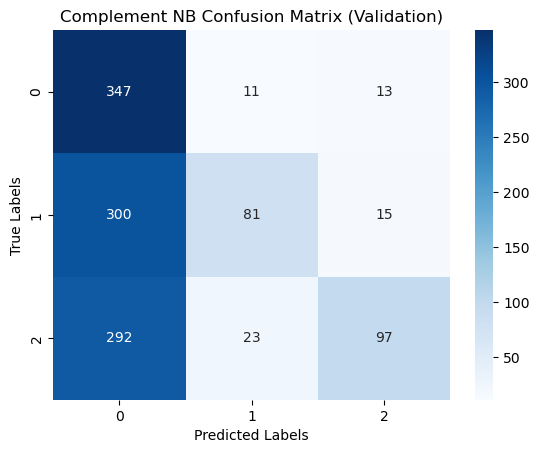

Results for Complement NB on Test Set:
              precision    recall  f1-score   support

    negative     0.3568    0.9037    0.5116       353
     neutral     0.6818    0.2314    0.3455       389
    positive     0.7386    0.2586    0.3831       437

    accuracy                         0.4427      1179
   macro avg     0.5924    0.4645    0.4134      1179
weighted avg     0.6055    0.4427    0.4092      1179


Specificity per class:
negative: 0.2609
neutral: 0.9114
positive: 0.9109

False Positive Rate (FPR) per class:
negative: 0.7391
neutral: 0.0886
positive: 0.0891

Weighted average specificity: 0.7165
Weighted average FPR: 0.2835

Macro average specificity: 0.6944
Macro average FPR: 0.3056


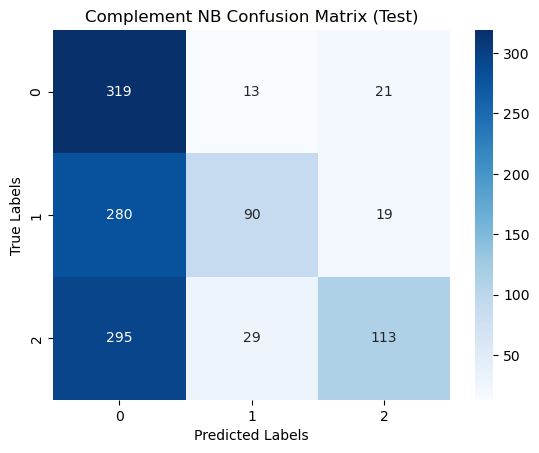

In [107]:
# Evaluate and display results for validation set
display_report(classifier_name, Y_val, predicted_val, "Validation")

# Evaluate and display results for test set
display_report(classifier_name, Y_test, predicted_test, "Test")

In [108]:
# For validation set
print("Misclassified Samples for Validation Set:")
display_sentences(Y_val, predicted_val, sentences_val)

# For test set
print("Misclassified Samples for Test Set:")
display_sentences(Y_test, predicted_test, sentences_test)


Misclassified Samples for Validation Set:

Misclassified headlines for negative sentiment:
Actual: negative, Predicted: positive, headlines: mustard seed futures slip on selling pressure
Actual: negative, Predicted: neutral, headlines: wagon supply delay drags texmaco into rs 35 crore loss
Actual: negative, Predicted: positive, headlines: mustard seed futures fall on hopes of good crop in growing regions
Actual: negative, Predicted: positive, headlines: jaypee infratech q1 net profit down 1171 to rs 20994 cr
Actual: negative, Predicted: positive, headlines: ashiana housing q1 net falls 17 pc to rs 797 crore

Misclassified headlines for neutral sentiment:
Actual: neutral, Predicted: negative, headlines: limited room left for further upside says p phani sekhar karvy stock broking
Actual: neutral, Predicted: negative, headlines: 6150 on the nifty looks a matter of time ashwani gujral
Actual: neutral, Predicted: negative, headlines: 35 per cent correction unlikely to affect markets p phani